In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# take a stratified subset of the training data, keeping only 5000 samples, with 500 samples per class
train_targets = train_dataset.targets
train_idx, _ = train_test_split(range(len(train_targets)), train_size=20000, stratify=train_targets)
train_dataset = torch.utils.data.Subset(train_dataset, train_idx)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


100%|██████████| 9.91M/9.91M [00:00<00:00, 59.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.72MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 12.8MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.8MB/s]


#Amortized VAE optimization

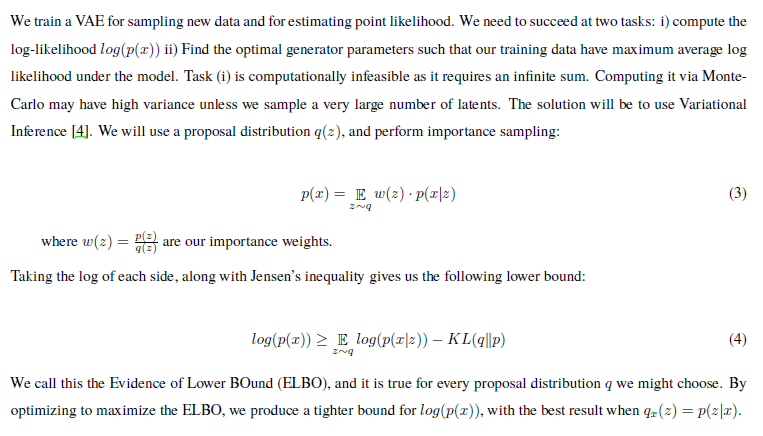

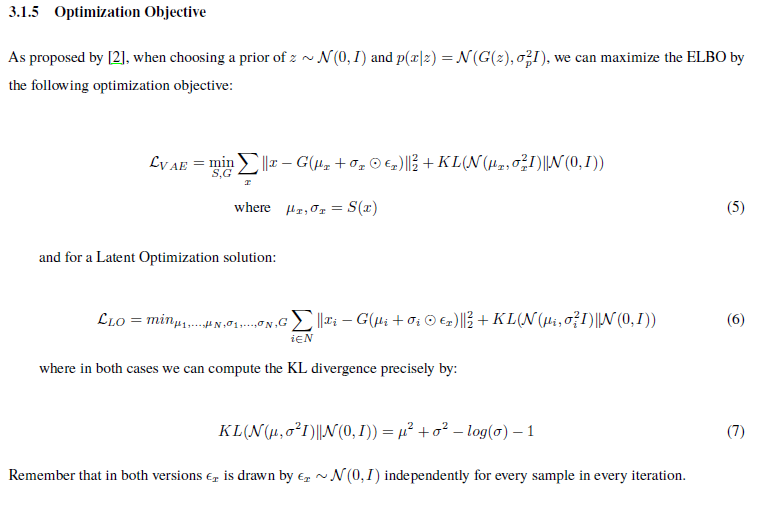

In [3]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F


class ConvVAE(nn.Module):
    def __init__(self, latent_dim=200):
        super(ConvVAE, self).__init__()

        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # (batch_size, 32, 14, 14)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # (batch_size, 64, 7, 7)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # (batch_size, 128, 4, 4)
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=2)  # (batch_size, 512, 1, 1)
        )


        # Latent space
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, 128)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=2),  # (batch_size, 128, 2, 2)
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch_size, 128, 4, 4)
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),  # (batch_size, 64, 7, 7)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch_size, 32, 14, 14)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch_size, 1, 28, 28)
        )

    def reparameterize(self, mu, logvar):
        ################## YOUR CODE HERE ######################
        std  = torch.exp(0.5 * logvar)
        eps  = torch.randn_like(std)
        z = mu + eps * std
        return z
        ########################################################

    def encode(self, x):
        x = self.encoder(x)
        # add average pooling
        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(x.size(0), -1)  # Flatten
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def decode(self, z):
        z = self.fc_decode(z)
        z = z.view(z.size(0), 128, 1, 1)
        z = self.decoder(z)
        return z

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

def vae_loss(recon, x, mu, logvar, sigma_p=0.4):
  ''' This function calclulate the loss'''
  recon_loss = F.mse_loss(recon, x, reduction='sum') / (x.size(0)*2*sigma_p**2)   # Reconstruction loss (MSE because p(x|z) is Gaussian)
  kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())/ x.size(0)    # KL divergence (analytic) # Normalize by batch size
  return recon_loss + kl_div



def sample_10_digits(dataset):
  ''' Sample 1 example per digit 0–9, in order '''
  digits = {i: None for i in range(10)}
  for img, label in dataset:
      if digits[label] is None:
          digits[label] = img
      if all(v is not None for v in digits.values()):
          break
  return torch.stack([digits[i] for i in range(10)])

def denormalize(tensor):
    return tensor * 0.5 + 0.5 # Inverse of (x - 0.5) / 0.5 → x = x' * 0.5 + 0.5

import matplotlib.pyplot as plt

def plot_all_recons(recons_dict, key_epochs, set_name):
    """
    Plot original and reconstructed digits across multiple epochs for train/test set.
    """
    num_digits = 10
    num_cols = 1 + len(key_epochs)  # 1 original + N reconstructions
    fig, axes = plt.subplots(nrows=num_digits, ncols=num_cols, figsize=(2 * num_cols, 2 * num_digits))

    # Get original samples
    originals, _ = recons_dict[set_name][key_epochs[0]]

    for i in range(num_digits):
        # Column 0: Original
        ax = axes[i][0]
        ax.imshow(denormalize(originals[i]).squeeze(), cmap='gray')
        ax.set_title("Original" if i == 0 else "")
        ax.axis('off')

        # Following columns: reconstructions for each epoch
        for j, epoch in enumerate(key_epochs):
            _, recons = recons_dict[set_name][epoch]
            ax = axes[i][j + 1]
            ax.imshow(denormalize(recons[i]).squeeze().detach(), cmap='gray')
            if i == 0:
                ax.set_title(f"Epoch {epoch}")
            ax.axis('off')

    plt.suptitle(f"{set_name.capitalize()} Set Reconstructions Over Epochs", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()


Epoch 1: Loss = 702.55 | Test Loss = 585.47
Epoch 2: Loss = 522.64 | Test Loss = 419.45
Epoch 3: Loss = 373.02 | Test Loss = 333.33
Epoch 4: Loss = 312.09 | Test Loss = 291.78
Epoch 5: Loss = 280.86 | Test Loss = 265.26
Epoch 6: Loss = 252.90 | Test Loss = 240.29
Epoch 7: Loss = 237.30 | Test Loss = 232.53
Epoch 8: Loss = 227.67 | Test Loss = 224.06
Epoch 9: Loss = 219.37 | Test Loss = 216.12
Epoch 10: Loss = 211.77 | Test Loss = 211.46
Epoch 11: Loss = 204.91 | Test Loss = 204.99
Epoch 12: Loss = 199.04 | Test Loss = 200.71
Epoch 13: Loss = 192.68 | Test Loss = 194.74
Epoch 14: Loss = 186.84 | Test Loss = 192.00
Epoch 15: Loss = 182.15 | Test Loss = 184.44
Epoch 16: Loss = 177.87 | Test Loss = 182.71
Epoch 17: Loss = 174.07 | Test Loss = 180.07
Epoch 18: Loss = 171.22 | Test Loss = 176.45
Epoch 19: Loss = 167.82 | Test Loss = 174.22
Epoch 20: Loss = 165.18 | Test Loss = 171.55
Epoch 21: Loss = 163.16 | Test Loss = 171.73
Epoch 22: Loss = 161.15 | Test Loss = 170.89
Epoch 23: Loss = 15

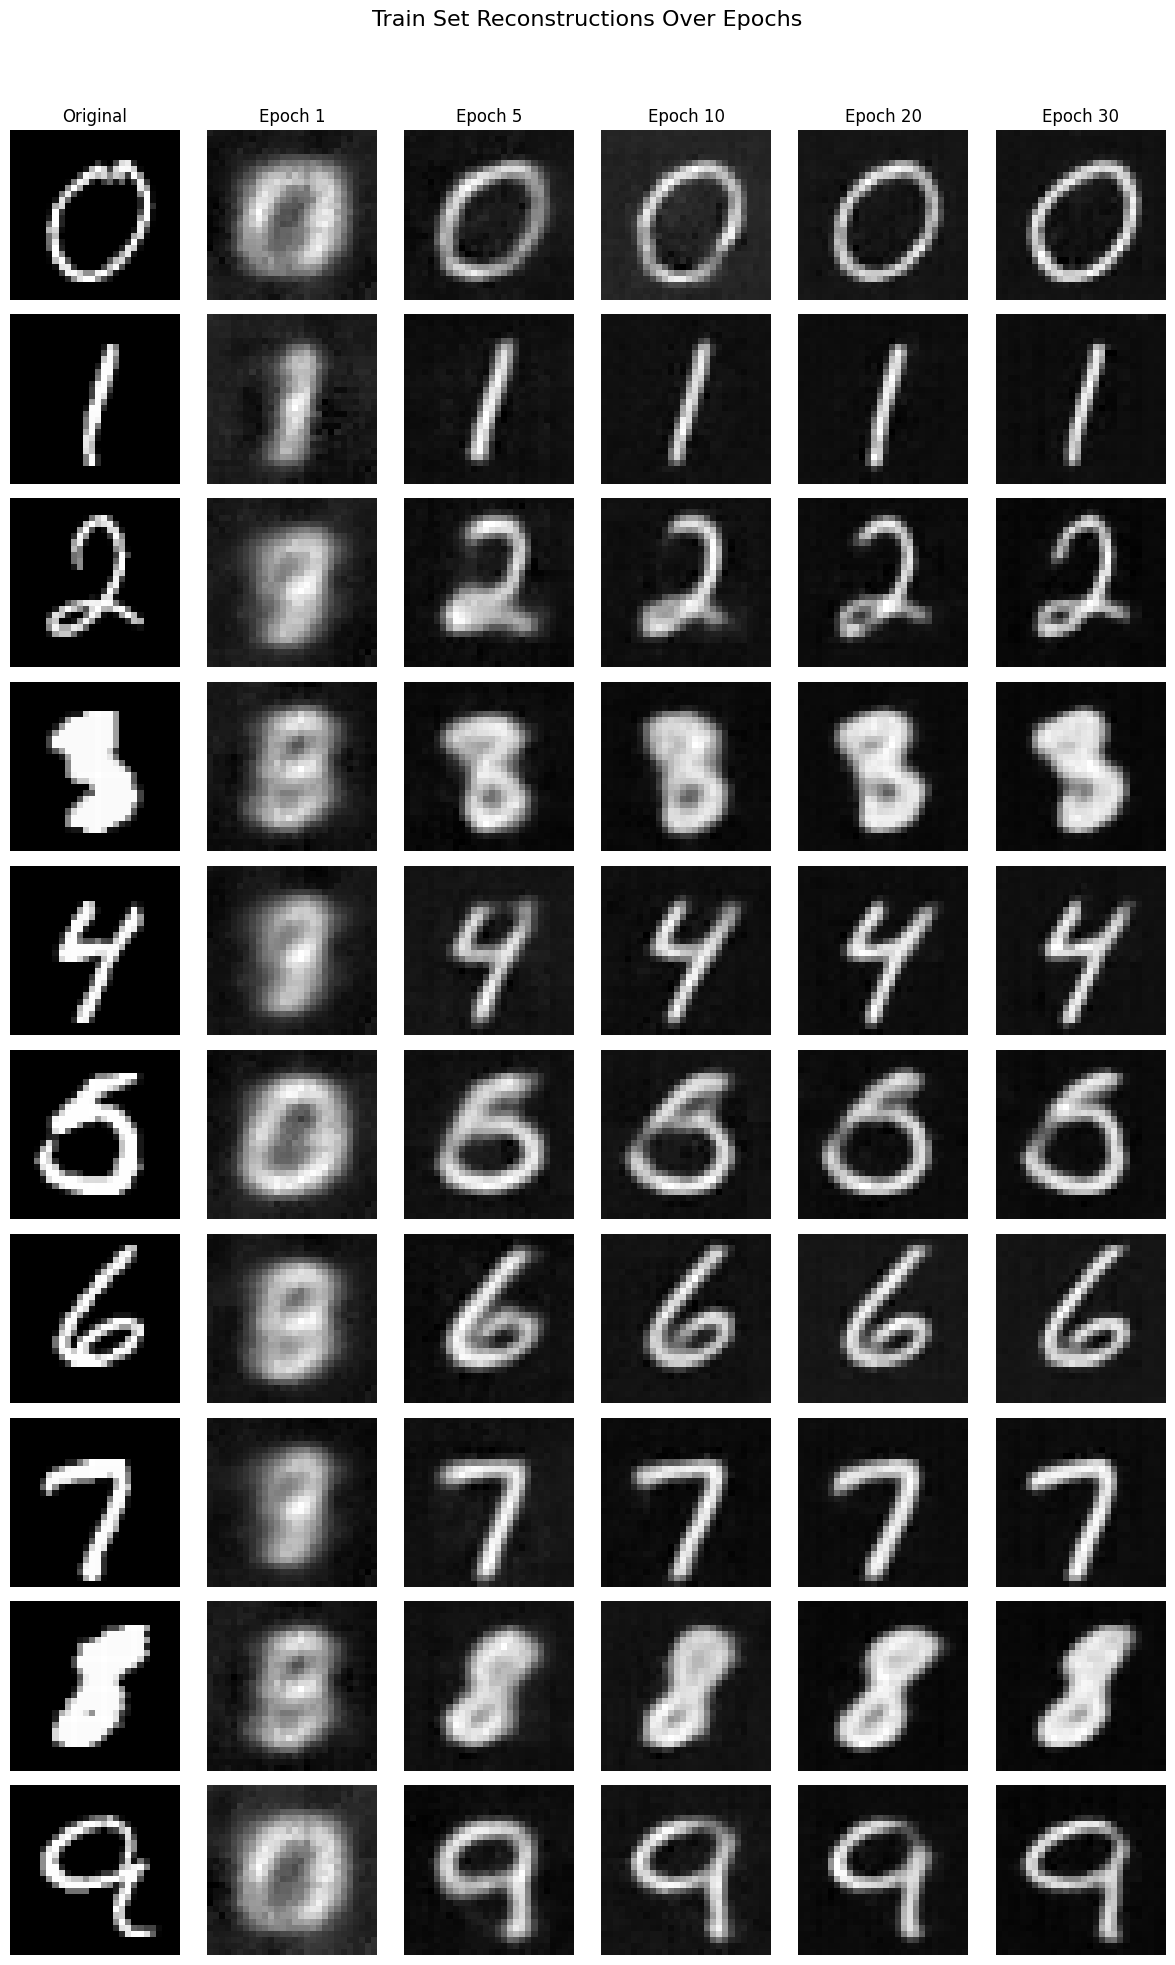

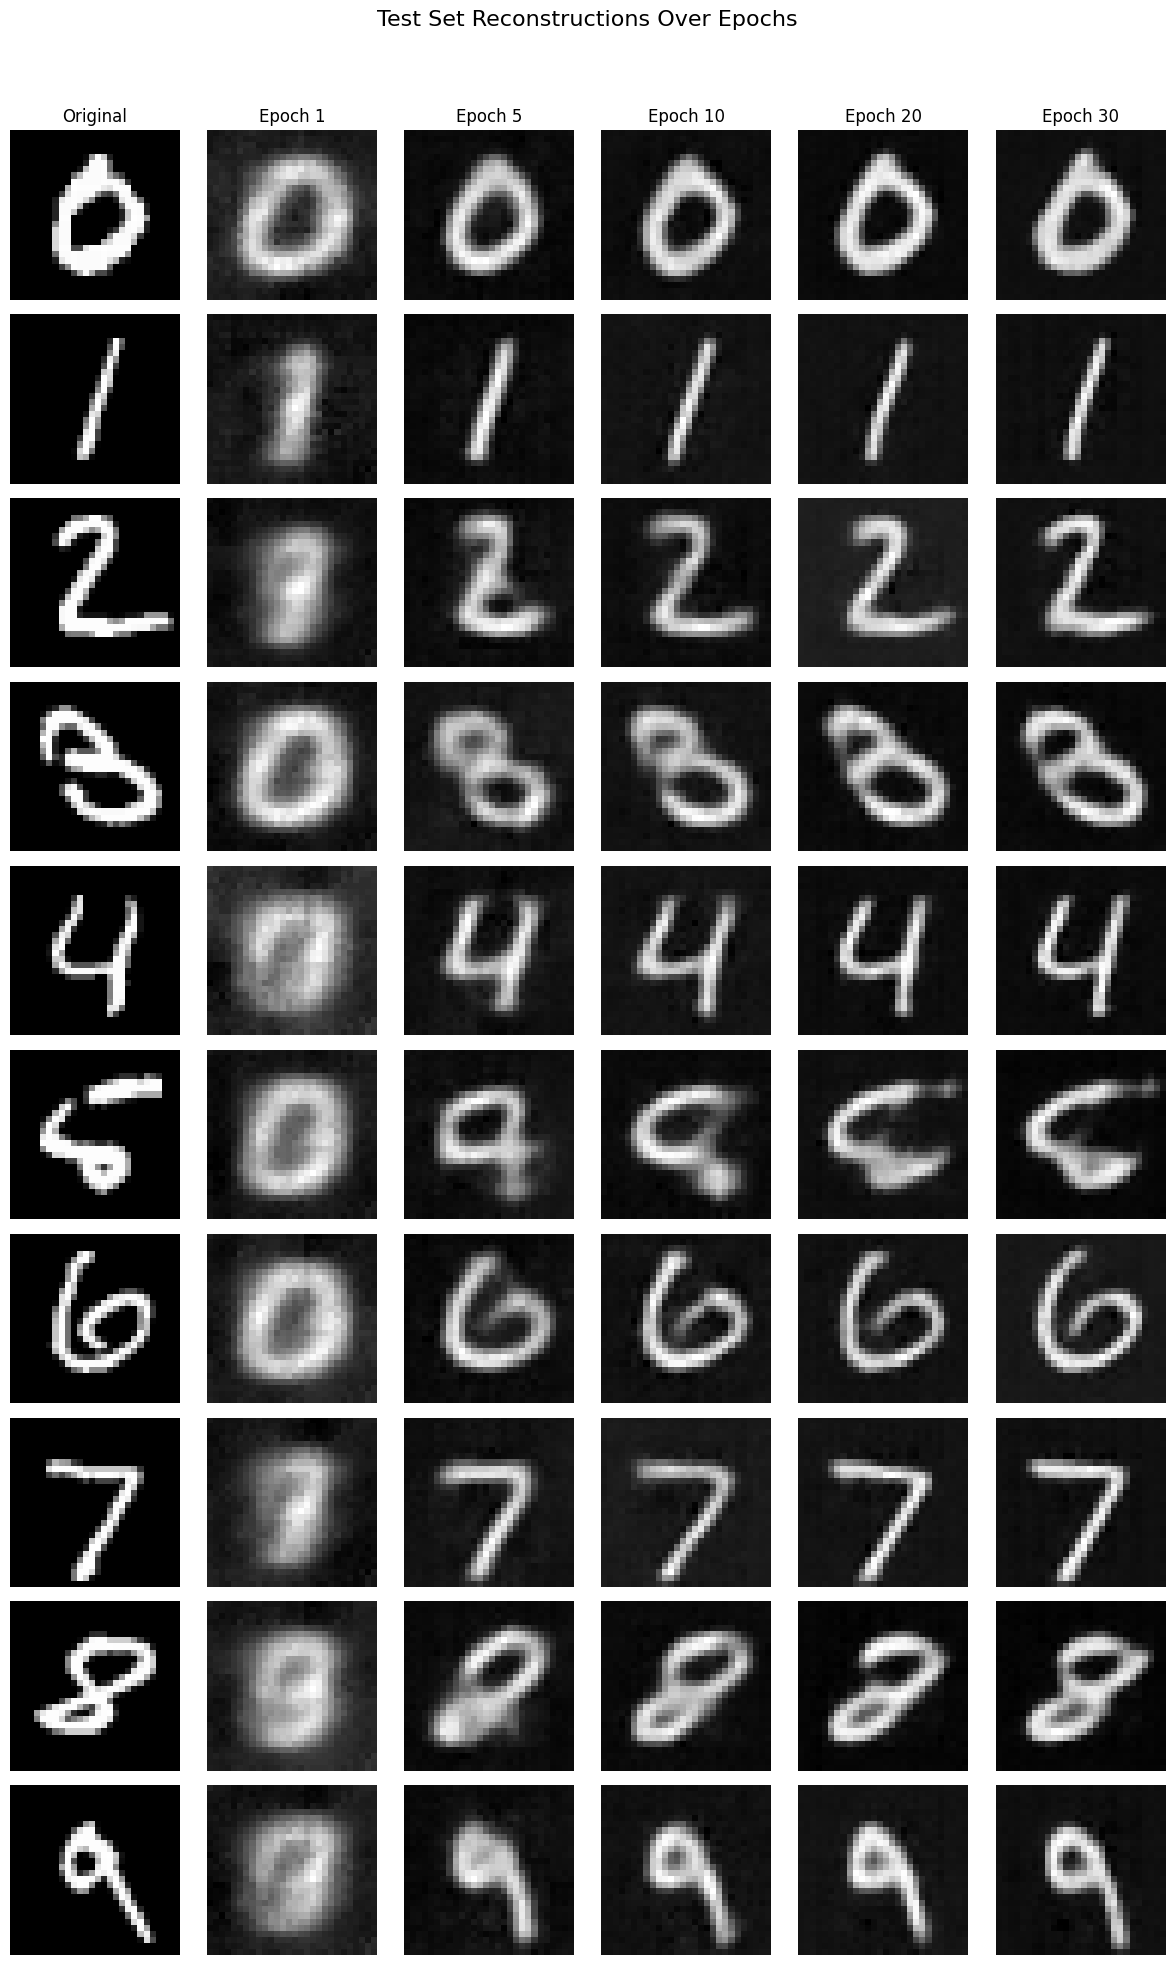

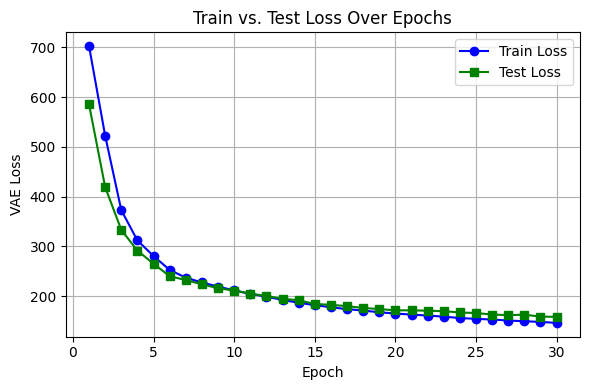

In [4]:


vae = ConvVAE(latent_dim=200)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

epochs = 30
train_losses = []
test_losses = []
key_epochs = [1, 5, 10, 20, 30]

recons_dict = {'train': {}, 'test': {}}


# Pick 10 fixed samples from training and test (one from each digit class)
sample_train = sample_10_digits(train_dataset)
sample_test = sample_10_digits(test_dataset)

for epoch in range(1, epochs + 1):
    vae.train()
    total_loss = 0

    for images, _ in train_loader:
        optimizer.zero_grad()
        recon, mu, logvar = vae(images) # This is __call_ function from nn.moudle. This automaticli call forward.
        loss = vae_loss(recon, images, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)


    vae.eval()
    test_total_loss=0
    with torch.no_grad():
        for images, _ in test_loader:
            recon, mu, logvar = vae(images)
            loss = vae_loss(recon, images, mu, logvar)
            test_total_loss += loss.item()
    avg_test_loss = test_total_loss / len(test_loader)
    test_losses.append(avg_test_loss)


    print(f"Epoch {epoch}: Loss = {avg_loss:.2f} | Test Loss = {avg_test_loss:.2f}")
    # save the model in it key_epochs
    if epoch in key_epochs:
      torch.save(vae.state_dict(), f"vae_epoch_{epoch}.pt")

    if epoch in key_epochs:
        vae.eval()
        with torch.no_grad():
            for name, images in [('train', sample_train), ('test', sample_test)]:
                recon, _, _ = vae(images)
                recons_dict[name][epoch] = (images, recon)



plot_all_recons(recons_dict, key_epochs, 'train')
plot_all_recons(recons_dict, key_epochs, 'test')

plt.figure(figsize=(6, 4))
plt.plot(range(1, epochs + 1), train_losses, marker='o',color='blue')
plt.plot(range(1, epochs + 1), test_losses, marker='s',color='green')
plt.legend(['Train Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('VAE Loss')
plt.title('Train vs. Test Loss Over Epochs')
plt.grid()
plt.tight_layout()
plt.show()


torch.save(vae.state_dict(), "final_vae_model.pt")


The following figures visualize the reconstruction quality of the trained Variational Autoencoder (VAE) over different training epochs, for both the training and test sets. For each digit (0–9), a representative image was selected, and its reconstruction is shown across five key epochs: 1, 5, 10, 20, and 30.

From the training set reconstructions, we observe that the model rapidly improves reconstruction quality over the first 10 epochs, transitioning from blurry and indistinct outputs to well-formed digit structures. By epoch 30, the reconstructions are almost indistinguishable from the originals for most classes, indicating strong memorization of training samples.

In contrast, test set reconstructions demonstrate a similar but slightly more restrained improvement. While the overall clarity improves with training, the reconstructions remain slightly less precise than those from the training set. This suggests that the model generalizes reasonably well, but still benefits from some exposure bias — expected in generative models trained with a pixel-wise reconstruction loss.

The line plot at the bottom shows the VAE loss (ELBO) over 30 epochs, comparing training and test losses. The gap between training and test loss narrows consistently, and the monotonic decrease indicates stable optimization. The relatively small generalization gap implies that the model is not severely overfitting and maintains meaningful latent representations.

Overall, the VAE is successfully trained in the amortized setting and demonstrates both effective

#latent space optimization

In [5]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# take a stratified subset of the training data, keeping only 5000 samples, with 500 samples per class
train_targets = train_dataset.targets
train_idx, _ = train_test_split(range(len(train_targets)), train_size=20000, stratify=train_targets)
train_dataset = torch.utils.data.Subset(train_dataset, train_idx)
train_loader = DataLoader(train_dataset, batch_size=64) #, shuffle=True)

In [6]:
fixed_indices = {}
for idx, (img, label) in enumerate(train_dataset):
    if label not in fixed_indices:
        fixed_indices[label] = idx
    if len(fixed_indices) == 10:
        break
#sort fixed indices by key
fixed_indices = {k: fixed_indices[k] for k in sorted(fixed_indices)}

fixed_indices

{0: 18, 1: 7, 2: 5, 3: 3, 4: 0, 5: 6, 6: 20, 7: 1, 8: 4, 9: 14}

Epoch 1: Loss = 1000.15
Epoch 2: Loss = 871.26
Epoch 3: Loss = 834.02
Epoch 4: Loss = 779.06
Epoch 5: Loss = 705.49
Epoch 6: Loss = 641.35
Epoch 7: Loss = 591.20
Epoch 8: Loss = 554.46
Epoch 9: Loss = 525.50
Epoch 10: Loss = 498.70
Epoch 11: Loss = 473.67
Epoch 12: Loss = 450.29
Epoch 13: Loss = 430.68
Epoch 14: Loss = 412.43
Epoch 15: Loss = 396.23
Epoch 16: Loss = 382.53
Epoch 17: Loss = 371.40
Epoch 18: Loss = 360.41
Epoch 19: Loss = 349.23
Epoch 20: Loss = 339.13
Epoch 21: Loss = 329.18
Epoch 22: Loss = 320.45
Epoch 23: Loss = 312.20
Epoch 24: Loss = 305.51
Epoch 25: Loss = 298.33
Epoch 26: Loss = 294.08
Epoch 27: Loss = 289.26
Epoch 28: Loss = 284.73
Epoch 29: Loss = 279.82
Epoch 30: Loss = 275.93


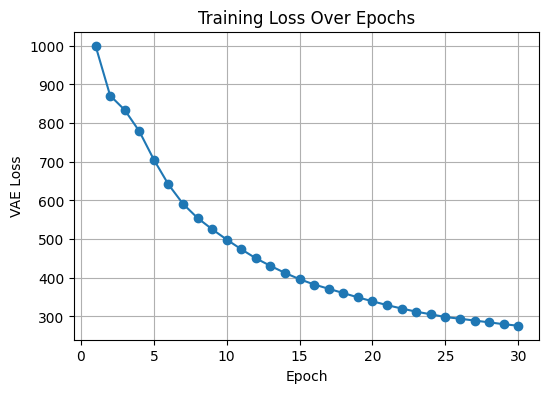

In [7]:
#init a model
vae = ConvVAE(latent_dim=200)

#init latent distiburions for all train examples
train_size = len(train_dataset)
q_mue = nn.Parameter(torch.randn(train_size, vae.latent_dim))
q_sig = torch.abs(torch.randn(train_size, vae.latent_dim))
q_logvar = nn.Parameter(2*torch.log(q_sig))

#combined optimizer with 2 diferent learning rates
optimizer = torch.optim.Adam([
    {'params': list(vae.decoder.parameters())+
                list(vae.fc_decode.parameters()), 'lr':1e-3},
    {'params': [q_mue,q_logvar], 'lr':1e-2}
])

#Training loop
epochs = 30
batch_size = train_loader.batch_size
train_losses = []
key_epochs = [1, 5, 10, 20, 30]
recons_dict = {}



for epoch in range(1, epochs+1):
  vae.train()
  running_loss = 0

  for batch_index, (images, _) in enumerate(train_loader):
    optimizer.zero_grad()


    #find the q distributions that correspond to this minibatch
    start_index = batch_index * batch_size
    end_index = min(start_index + batch_size, train_size)

    in_batch_indecies = torch.arange(start_index,
                                      end_index
                                      , dtype=torch.long)
    mue_batch = q_mue[in_batch_indecies]
    logvar_batch = q_logvar[in_batch_indecies]

    #reparametrize and decode
    z = vae.reparameterize(mue_batch,logvar_batch)
    recon = vae.decode(z)

    #calc loss
    loss = vae_loss(recon, images, mue_batch, logvar_batch)

    #optimize
    loss.backward()
    optimizer.step()
    running_loss += loss.item()


  epoch_loss = running_loss / len(train_loader)
  train_losses.append(epoch_loss)
  print(f"Epoch {epoch}: Loss = {epoch_loss:.2f}")

  if epoch in key_epochs:
    with torch.no_grad():
      idxs_fixes = torch.tensor([fixed_indices[i] for i in range(10)], dtype=torch.long)
      mue_fix = q_mue[idxs_fixes]
      logvar_fix = q_logvar[idxs_fixes]
      z_fix = vae.reparameterize(mue_fix, logvar_fix)
      recons_dict[epoch] = vae.decode(z_fix).clone()
    torch.save(vae.state_dict(), f"vae_epoch_{epoch}.pt")




plt.figure(figsize=(6, 4))
plt.plot(range(1, epochs + 1), train_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('VAE Loss')
plt.title('Training Loss Over Epochs')
plt.grid()


In this training run, the VAE was trained using latent optimization, where the variational parameters (means and log-variances) are treated as learnable parameters per datapoint rather than being predicted by an encoder. This method decouples the inference network from training and relies on directly optimizing latent representations for each training sample.

The plot shows a consistent decrease in VAE loss (ELBO) over 30 epochs, indicating stable convergence under this formulation. As expected, loss values start high due to initially uninformative latent vectors and gradually decline as the generator learns to decode more accurate reconstructions from better-optimized latent inputs.

Important note on training stability:
Unlike amortized VAEs, this training loop requires that each image in the dataset maintains a consistent index across epochs, because the learned latent vectors q_mu and q_logvar are tied to specific sample indices. Therefore, shuffle=True must not be used in the DataLoader. Shuffling would break the mapping between input images and their corresponding latent variables, leading to training instability and incorrect reconstructions. In this experiment, shuffle=False was explicitly set to preserve index alignment, which is crucial for successful latent optimization.



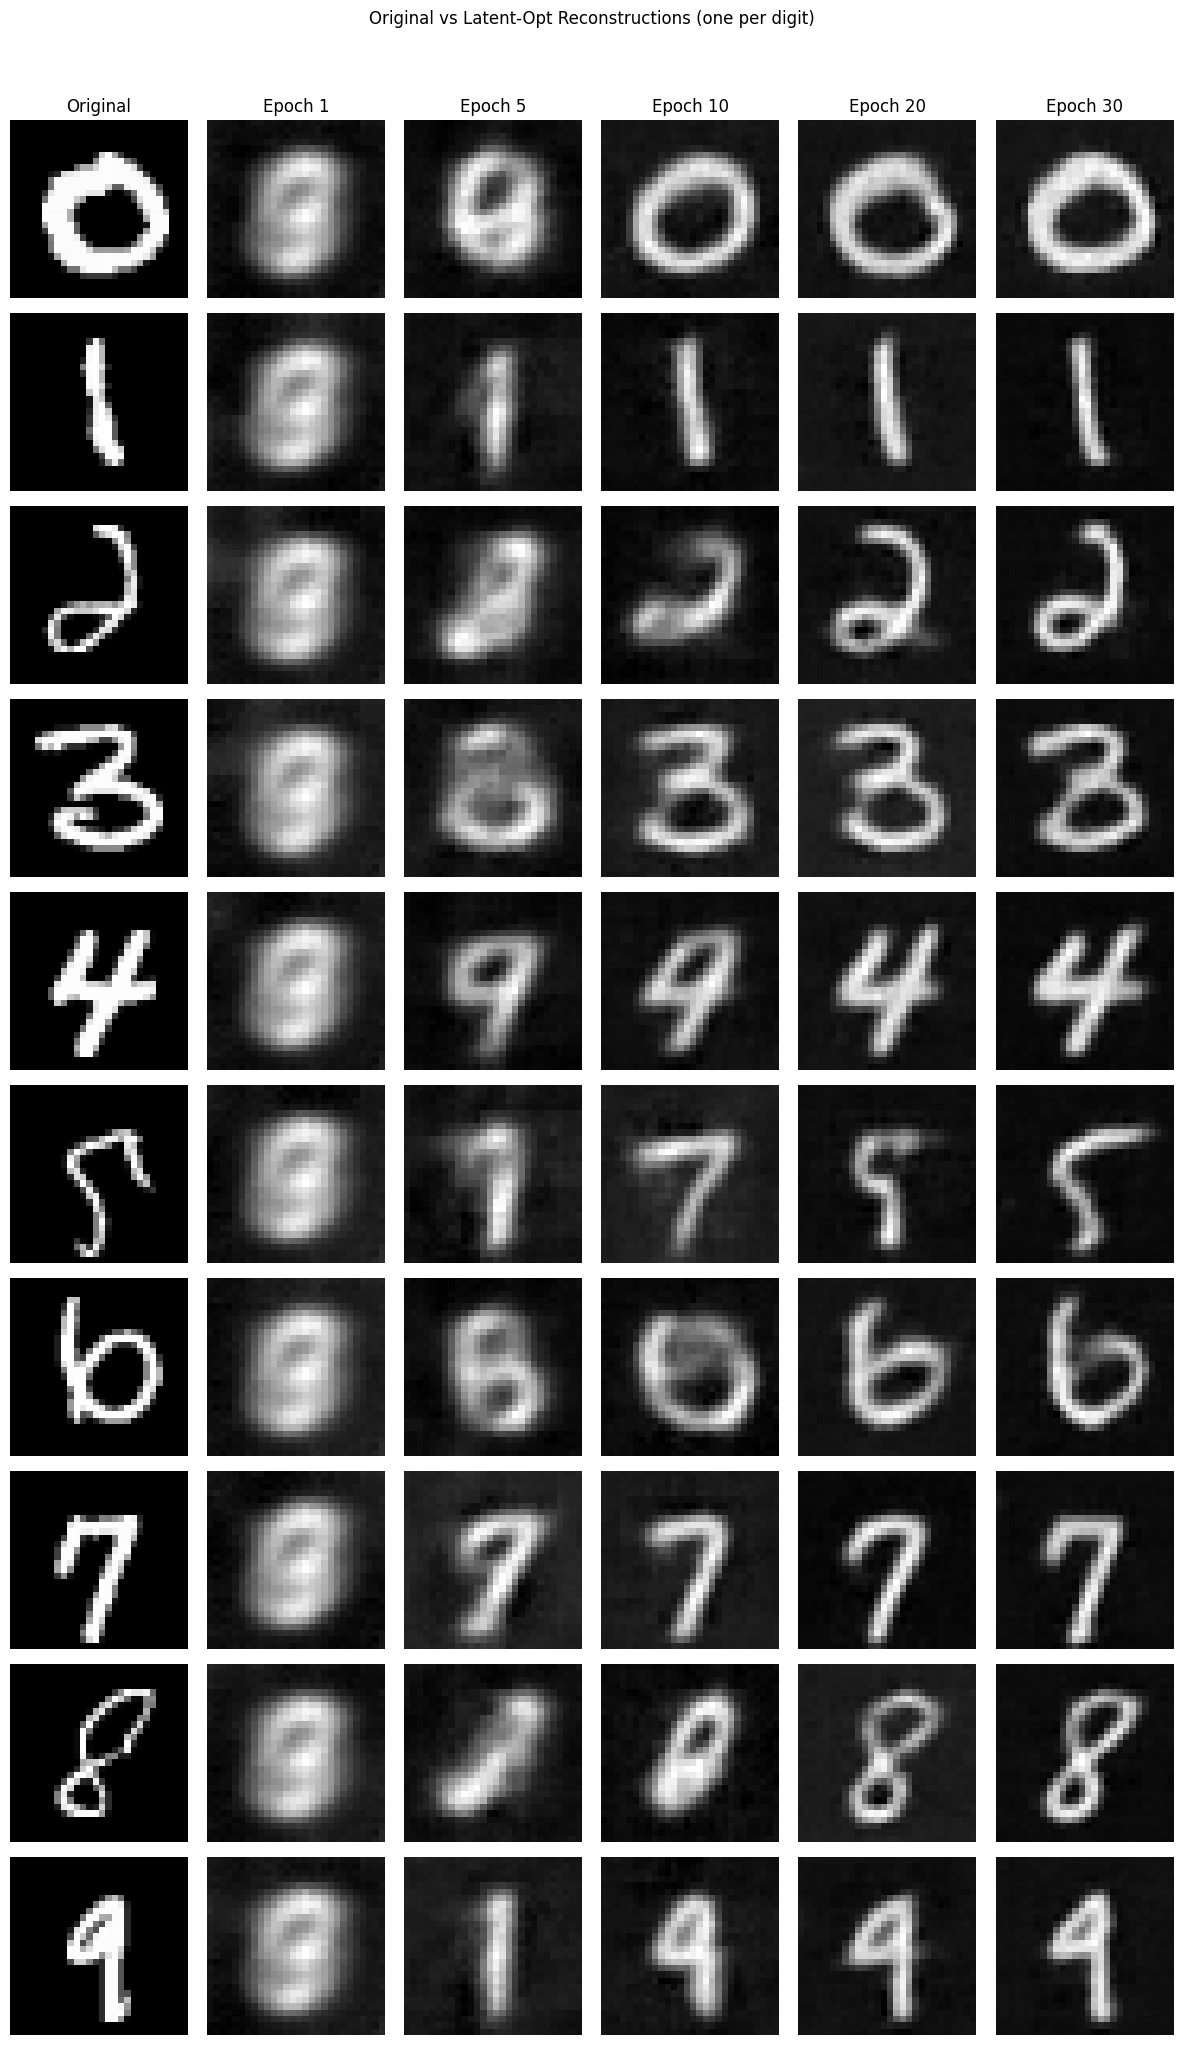

In [8]:
# 1) collect originals in the same order as your reconstructions
originals = torch.stack([
    train_dataset[fixed_indices[digit]][0]
    for digit in range(10)
]).to(images.device)   # move to same device if needed

# 2) plot “Original” + each key‐epoch
n_recons = len(key_epochs)
n_cols   = n_recons + 1

plt.figure(figsize=(2 * n_cols, 2 * 10))
for i in range(10):
    # column 0 = original
    ax = plt.subplot(10, n_cols, i * n_cols + 1)
    ax.imshow(denormalize(originals[i]).squeeze(), cmap='gray')
    ax.axis('off')
    if i == 0:
        ax.set_title("Original")

    # columns 1..n_recons = reconstructions
    for j, e in enumerate(key_epochs):
        ax = plt.subplot(10, n_cols, i * n_cols + (j + 2))
        ax.imshow(denormalize(recons_dict[e][i]).squeeze(), cmap='gray')
        ax.axis('off')
        if i == 0:
            ax.set_title(f"Epoch {e}")

plt.suptitle("Original vs Latent-Opt Reconstructions (one per digit)", y=1.02)
plt.tight_layout()
plt.show()


This figure shows a side-by-side comparison between the original MNIST digits (leftmost column) and their reconstructions across selected epochs when using latent optimization for inference. One representative sample per digit (0–9) was used to qualitatively assess how the decoder improves with time.

The reconstructions at early epochs (e.g., epoch 1) are significantly blurry and exhibit structural ambiguity. This is expected, as the latent vectors are initialized randomly and optimized individually from scratch. However, as training progresses, the reconstructions become more distinct and aligned with the target digits.

By epoch 30, most reconstructions are highly accurate and nearly indistinguishable from the originals, demonstrating the effectiveness of latent optimization in capturing meaningful latent codes even without amortized inference.

Notably, some digits (e.g., “5”, “9”) are slightly harder to reconstruct consistently, which may suggest increased complexity or ambiguity in their pixel structure. However, overall convergence is successful across all classes.

This visualization confirms that latent optimization, despite being slower to converge than amortized methods, can lead to high-quality reconstructions given sufficient training time.



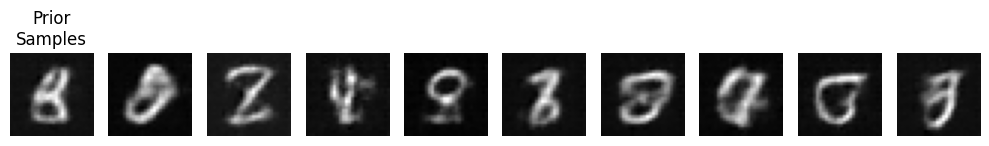

In [9]:
z_prior = torch.randn(10, vae.latent_dim)
with torch.no_grad():
    prior_samples = vae.decode(z_prior)

plt.figure(figsize=(10, 2))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    ax.imshow(denormalize(prior_samples[i]).squeeze(), cmap='gray')
    ax.axis('off')
    if i == 0:
        ax.set_title("Prior\nSamples")
plt.tight_layout()
plt.show()

#compute log-liklihood of an image

log(p(x)) ≈ logsumexp over i of [ log(p(x|zi)) + log(p(zi)) - log(q(zi|x)) ] - log(M)

In [10]:
def sample_per_digit(dataset, num=5):
    """Return dict digit→list of `num` images (shape [1,28,28])."""
    samples = {d: [] for d in range(10)}
    for img, label in dataset:
        if len(samples[label]) < num:
            samples[label].append(img.unsqueeze(0))
        if all(len(v)==num for v in samples.values()):
            break
    return samples


import matplotlib.pyplot as plt
import torch

def show_samples(samples, title="Samples"):
    """Display sampled images per digit."""
    fig, axes = plt.subplots(10, len(samples[0]), figsize=(len(samples[0]), 10))
    fig.suptitle(title, fontsize=16)

    for digit in range(10):
        for i, img in enumerate(samples[digit]):
            ax = axes[digit, i]
            ax.imshow(img.squeeze().numpy(), cmap="gray")
            ax.axis('off')
            if i == 0:
                ax.set_ylabel(f"{digit}", fontsize=12, rotation=0, labelpad=20)

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()


def reparametriz_multi_dim(mue, logvar, M):
  """
    mue, logvar: [batch_size, latent_dim]
    M:        number of samples per image

    returns z: [batch_size, M, latent_dim]
  """
  batch_size ,latent_dim = mue.shape
  eps = torch.randn(batch_size, M, latent_dim)
  std = torch.exp(0.5 * logvar)
  mue_e  = mue.unsqueeze(1).expand(-1, M, -1)
  std_e = std.unsqueeze(1).expand(-1, M, -1)
  z = mue_e + eps * std_e
  return z


def estimate_logpx(vae, x , M=1000, sigma_p=0.4):
  #x is the number of images, not one image
  vae.eval()

  with torch.no_grad():
    recon_0, mu_z, logvar = vae(x) # recon:[B,1,28,28], mu_z/logvar:[B,D]
    B , D = mu_z.shape
    z = reparametriz_multi_dim(mue = mu_z, logvar = logvar, M=1000) # z:[B,M,D]

    # Find log P(z) using the prior of N(0,I)
    prior_z = torch.distributions.normal.Normal(torch.zeros_like(z), torch.ones_like(z))
    logpz = prior_z.log_prob(z).sum(dim=2)

    # log q(z|x) using the distribution N(muex, σx)
    sigma_z = torch.exp(0.5 * logvar)                                 # [B, 28*28]
    sigma_z_expanded = sigma_z.unsqueeze(1).expand(-1, M, -1)           # [B, M, 28*28]
    mue_z_expanded = mu_z.unsqueeze(1).expand(-1, M, -1)              # [B, M, 28*28]
    q_z_given_x = torch.distributions.normal.Normal(mue_z_expanded, sigma_z_expanded)

    logqz_given_x = q_z_given_x.log_prob(z).sum(dim=2)   # [B, M]

    # log P(x|zi) using the g(x). P(x|zi)~N(g(x),sigma_p*I )
    z_flat = z.view(B*M, D)    # z:[B,M,D] --> z:[Batch=50 * MonteCarlo=1000 , D=200]
    recon_z = vae.decode(z_flat) #recon_z: [B*M,1,28,28]
    recon_z  = recon_z.view(B, M, 1, 28, 28) #recon_z: [B,M,1,28,28]

    #preper x to match the dimention by brodcasting
    x_expanded= x.unsqueeze(1).expand(-1,M,-1,-1,-1)
    px_given_z_dist = torch.distributions.Normal(loc=recon_z, scale=sigma_p)
    logPxz = px_given_z_dist.log_prob(x.unsqueeze(1)).sum(dim=(2, 3, 4))  # sum over C,H,W → [B, M]

    log_w = logPxz + logpz - logqz_given_x  # [B, M]
    logpx = torch.logsumexp(log_w, dim=1) - torch.log(torch.tensor(M, dtype=torch.float32))

    return logpx


In [11]:
train_samples = sample_per_digit(train_dataset,  num=5)
test_samples  = sample_per_digit(test_dataset,  num=5)

x_train = torch.cat([torch.cat(train_samples[d], dim=0) for d in range(10)], dim=0)  # [50,1,28,28]
x_test  = torch.cat([torch.cat(test_samples[d],  dim=0) for d in range(10)], dim=0)  # [50,1,28,28]


# x_train, x_test each have shape [50,1,28,28]
logp_train = estimate_logpx(vae, x_train, M=1000, sigma_p=0.4)
logp_test  = estimate_logpx(vae, x_test,  M=1000, sigma_p=0.4)

import numpy as np
avg_per_digit = {
  d: torch.cat([logp_train[d*5:d*5+5], logp_test[d*5:d*5+5]]).mean().item()
  for d in range(10)
}
avg_per_digit

{0: -570.0059814453125,
 1: -195.91336059570312,
 2: -514.733154296875,
 3: -556.2362060546875,
 4: -394.6275939941406,
 5: -416.90191650390625,
 6: -548.6590576171875,
 7: -455.123291015625,
 8: -470.1481018066406,
 9: -358.1124267578125}

In [12]:
print("Train avg:", logp_train.mean().item())
print(" Test avg:", logp_test.mean().item())


Train avg: -461.9953918457031
 Test avg: -434.09686279296875


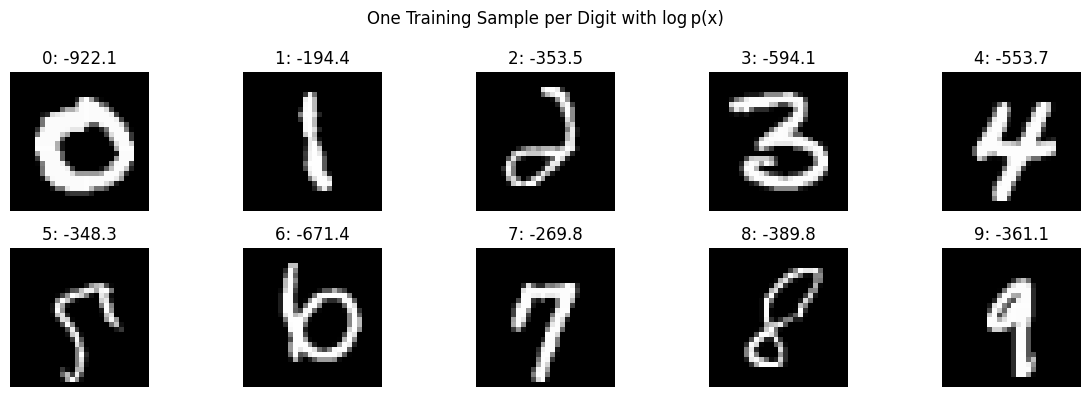

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
for d in range(10):
    # pick the first of the 5 training samples for digit d
    img = train_samples[d][0]               # shape [1,28,28]
    lp  = logp_train[d*5 + 0].item()        # index d*5 in the 50-length vector

    ax = plt.subplot(2, 5, d+1)
    ax.imshow(denormalize(img).squeeze(), cmap='gray')
    ax.set_title(f"{d}: {lp:.1f}")
    ax.axis('off')

plt.suptitle("One Training Sample per Digit with log p(x)")
plt.tight_layout()
plt.show()

In [14]:
import numpy as np

avg_per_digit = {}
for d in range(10):
    # indices for train: d*5 … d*5+4
    tr_vals = logp_train[d*5:(d+1)*5]
    # indices for test:  50 + d*5 … 50 + d*5+4
    te_vals = logp_test[d*5:(d+1)*5]
    all_vals = torch.cat([tr_vals, te_vals], dim=0)
    avg_per_digit[d] = all_vals.mean().item()
    print(f"Digit {d}: avg log p = {avg_per_digit[d]:.2f}")

# find the most likely digit
most_likely = max(avg_per_digit, key=avg_per_digit.get)
print(f"\n→ Most likely digit: {most_likely} (highest avg log p)")




Digit 0: avg log p = -570.01
Digit 1: avg log p = -195.91
Digit 2: avg log p = -514.73
Digit 3: avg log p = -556.24
Digit 4: avg log p = -394.63
Digit 5: avg log p = -416.90
Digit 6: avg log p = -548.66
Digit 7: avg log p = -455.12
Digit 8: avg log p = -470.15
Digit 9: avg log p = -358.11

→ Most likely digit: 1 (highest avg log p)


### Estimating Log-Likelihood via Importance Sampling

We estimate the log-likelihood \\(\log p(x)\\) for a set of 50 MNIST images (5 per digit, from both train and test sets) using importance sampling with 1,000 latent samples per image. The estimation follows the log-sum-exp approximation:

\\[
\log p(x) \approx \log \left( \frac{1}{M} \sum_{i=1}^M \frac{p(z_i) \cdot p(x|z_i)}{q(z_i|x)} \right)
\\]

This allows us to evaluate how well the VAE assigns likelihood to unseen images, and compare performance across digits and between datasets.

---

### Results Summary

- **Per-digit log-likelihoods**:  
  Digits such as **1** achieved much higher average likelihoods (≈ -196), suggesting they are simpler and more consistently encoded.  
  In contrast, digits like **0**, **2**, and **3** had much lower scores (≈ -500 to -570), likely due to their visual variability.

- **Dataset Comparison**:
  - **Train average**: ~**-462**
  - **Test average**: ~**-434**

Interestingly, the test set samples received **slightly higher log-likelihood** on average than the training samples. This could result from overfitting of latent vectors during training, or from the effect of the KL divergence regularization improving generalization.

---

### Visualizations

- **Bar Plot – Average Log-Likelihood per Digit**  
  A bar chart is plotted to show the mean log-likelihood for each digit (0–9), based on 10 samples per digit (5 train + 5 test).

- **Bar Plot – Train vs. Test (Overall)**  
  A grouped bar chart is also shown to compare the overall average log-likelihood between train and test sets.

These visualizations help interpret how well the VAE models each digit and how consistent its generative behavior is across datasets.
